# Esercizio 7
Questo esercizio mostra l'utilizzo di una rete neurale per classificare due classi di eventi in due dimensioni. 

## Funzione di test
Date due ipotesi $H_0$ (fondo) e $H_1$ (segnale) da discriminare, per il lemma di Neyman-Person la statistica di test con maggiore potenza discriminante a parità di livello di significanza è la *likelihood ratio*:
\begin{equation}
g(\vec{x}) =  \frac{ \mathcal{L(\vec{x} | H_0})}{\mathcal{L}(\vec{x}| H_1)}
\end{equation}
Le likelihood possono essere generate con metodi MC oppure la funzione di test può essere approssimita da una rete neurale. I pesi della rete devono essere ottimizzati per rappresentare il rapporto delle likelihood attraverso una fase di training in cui si minimizza una funzione di errore. 

In [20]:
import keras
from keras.models import Sequential
from keras.layers import Dense
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
# matplotlib settings
mpl.rc('axes', titlesize=18)
mpl.rc('axes', labelsize=18)
mpl.rc('axes', grid=True)
mpl.rc('grid', linestyle=':')
mpl.rc('legend', fontsize=20)
mpl.rc('figure', figsize=(14, 11))
mpl.rc('xtick', labelsize=16)
mpl.rc('ytick', labelsize=16)

### Struttura della rete
Il modello utilizzato prevede un hidden layer con 5 neuroni. L'output della rete è un singolo neurone con funzione di attivazione sigmoide logistica, ottimale per i problemi di categorizzazione binari. 
\begin{equation}
f(x) = \frac{1}{1 - e^{-x}}
\end{equation}. 

La funzione di attivazione dei livelli intermedi è detta rectifier e ha forma
\begin{equation}
    f(x) = \max(0, x)
\end{equation}

I pesi all'interno della rete vengono inizializzati tutti con una distribuzione gaussiana attorno a 0. 

### Loss function
La loss function utilizzata in questa rete neurale è detta *cross-entropy* ed è definita come:
\begin{equation}
H(p,q ) = - \sum_i p_i \log(q_i)
\end{equation}
dove $p_i$ rappresenta la distribuzione (discreta) vera e $q_i$ la distribuzione da confrontare con $p_i$. 
Nel caso della categorizzazione binaria vogliamo assegnare l'etichetta 1 o 0 a un dato per distringere l'insieme $H_0$ da $H_1$. 

$p_i$ rappresenta l'etichetta vera di un dato, $q_i$ rappresenta il valore predetto dal modello (la rete neurale) attraverso la funzione sigmoide logistica. 
\begin{equation}
q_i = \frac{1}{1- e^{\vec{w}\cdot\vec{x}}}
\end{equation}
con $\vec{w}$ pesi della rete e $\vec{x}$ valori di input (in queste esempio si parla di modello a singolo perceptrone).

La loss function cross-entropy viene utilizzata per calcolare la distanza tra queste due distribuzioni di probabilità che viene poi utilizzata per ottimizzare i pesi della rete attraverso la tecnica dello *stochastic gradient descent*



In [2]:
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(5, input_dim=2, kernel_initializer='normal', activation='relu'))
   # model.add(Dense(4, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model with mean squared errors and stocastic gradient descent
    model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return model

In [3]:
model = create_model()
# print ("Now we load weight")
# if os.path.isfile("model.h5"):
#     model.load_weights("model.h5")
#     adam = Adam(lr=LEARNING_RATE)
#     model.compile(loss='mse',optimizer=adam)
#     print ("Weight load successfully")    
keras.utils.print_summary(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 5)                 15        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [4]:
keras.utils.plot_model(model, to_file='model.png',show_shapes=True, rankdir='TB')

Si generano samples per il segnale e il fondo utilizzando gaussiane multivariate

In [6]:
Nset = 500000
# signal parameters
mean_signal  = [4,4]
cov_signal = [ [1 , 0], [0, 1]]

signal_samples = np.random.multivariate_normal(mean_signal, cov_signal, Nset)
labels_signal = np.ones((Nset, 1))

# background parameters
mean_bkg  = [0,1]
rho = 0.7
sigma = 1.5
cov_bkg = [ [ sigma**2 , sigma**2 * 0.7], [ sigma**2 * 0.7, sigma**2 ]]

bkg_samples = np.random.multivariate_normal(mean_bkg, cov_bkg, Nset)
labels_bkg = np.zeros((Nset, 1))

In [7]:
data = np.append(signal_samples, bkg_samples, axis=0)
labels = np.append(labels_signal, labels_bkg, axis=0)

### Stratified K-folding e training
In questo esempio è stata implementata una tecnica di cross-validation per il training e il test della rete neurale.
In particolare la *Stratified k-fold validation* consiste di dividere un dataset in $k$ partizioni mantenendo in ognuna la stessa percentuale di elementi per etichetta. La rete neurale viene poi trainata $k$ volte sugli elementi di $k-1$ partizioni a rotazione, eseguendo il test delle performance sulla partizione rimasta. Questa tecnica permette di valutare la bontà del modello e di prevenire l'overfitting.  

In [8]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [9]:
histories = []
scores = []
for train, test in kfold.split(data, labels):
    model = create_model()
    history = model.fit(data[train], labels[train], epochs=3, batch_size=32)
    histories.append(history)
    score = model.evaluate(data[test], labels[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
    scores.append(score[1]*100)
    
print("%.2f%% (+/- %.2f%%)" % (np.mean(scores), np.std(scores)))

Epoch 1/3
800000/800000 [==============================] - 28s 35us/step - loss: 0.1464 - acc: 0.9429
Epoch 2/3
800000/800000 [==============================] - 28s 35us/step - loss: 0.1139 - acc: 0.9587
Epoch 3/3
800000/800000 [==============================] - 28s 35us/step - loss: 0.1138 - acc: 0.9586
acc: 95.93%
Epoch 1/3
800000/800000 [==============================] - 28s 35us/step - loss: 0.1387 - acc: 0.9515
Epoch 2/3
800000/800000 [==============================] - 28s 35us/step - loss: 0.1146 - acc: 0.9588
Epoch 3/3
800000/800000 [==============================] - 28s 35us/step - loss: 0.1142 - acc: 0.9588
acc: 95.86%
Epoch 1/3
800000/800000 [==============================] - 29s 36us/step - loss: 0.1453 - acc: 0.9461
Epoch 2/3
800000/800000 [==============================] - 28s 35us/step - loss: 0.1166 - acc: 0.9585
Epoch 3/3
800000/800000 [==============================] - 28s 35us/step - loss: 0.1144 - acc: 0.9587
acc: 95.93%
Epoch 1/3
800000/800000 [=====================

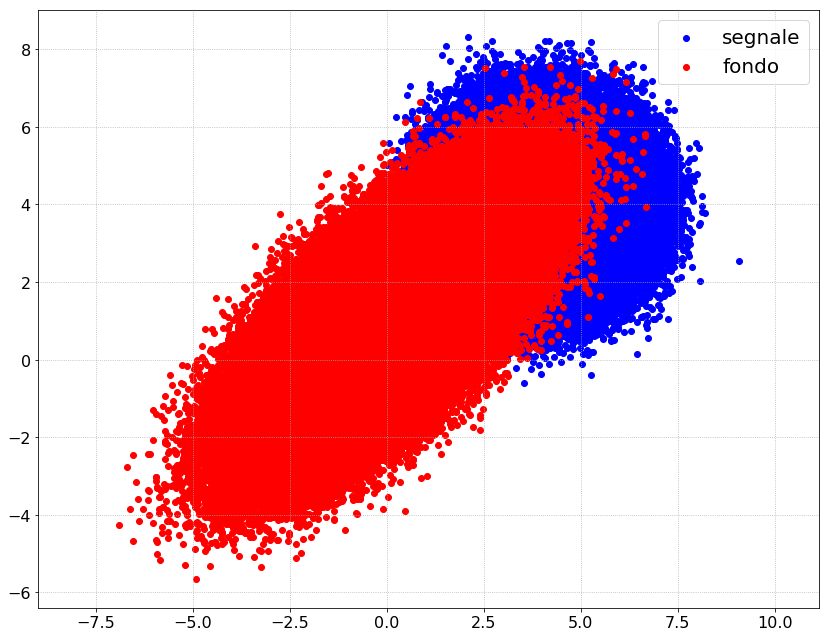

In [55]:
x_signal, y_signal = signal_samples.T
x_bkg, y_bkg = bkg_samples.T

plt.scatter(x_signal, y_signal, c="b", label="segnale")
plt.scatter(x_bkg, y_bkg, c="r", label="fondo")
plt.legend()
plt.axis("equal")
plt.show()

In [22]:
plt.plot(histories[0].epoch, histories[0].history["loss"])
plt.show()

# Test delle performance
Dopo il training della rete con cross-validation si vogliono visualizzare i risultati ottenuti applicando la funzione di test (la rete neurale) a un set di dati di segnale e fondo. Si vogliono analizzare livello di significanza e potenza del test statistico ottenuto. Il valore di soglia che distingue le due classi per cui è stata ottimizzata la rete è $t_{cut} = 0.5$.

La potenza del test statistico (o purezza del segnale) è definita come $1-\beta$ :
\begin{equation}
1 - \beta =  \int_{0.5}^{1} g(t | H_1) dt 
\end{equation}
dove $g(t|H_1)$ rappresenta la distribuzione dei risultati dell'applicazione della rete neurale al sample del segnale, con $t\in[0,1]$. 

Il livello di significanza del test (o tasso di falsi positivi) è definito come:
\begin{equation}
\alpha = \int_{0.5}^1 g(t|H_0)dt
\end{equation}
dove $g(t|H_0)$ rappresenta la distribuzione dei risultati dell'applicazione della rete neurola al sample del fondo. 
La rigezione del fondo può essere definita come il livello di confidenza del test, cioè $1-\alpha$.


In [44]:
signal_samples_test = np.random.multivariate_normal(mean_signal, cov_signal, 10000)
bkg_samples_test = np.random.multivariate_normal(mean_bkg, cov_bkg, 10000)

In [45]:
results_signal = model.predict(signal_samples_test)
results_bkg = model.predict(bkg_samples_test)

In [64]:
print("Purezza del segnale : {:.2f}%".format(100 * (results_signal>0.5).sum()/ 10000))
print("Rigezione del fondo: {:.2f}%". format(100* (results_bkg < 0.5).sum()/ 10000))

Purezza del segnale : 96.50%
Rigezione del fondo: 95.36%


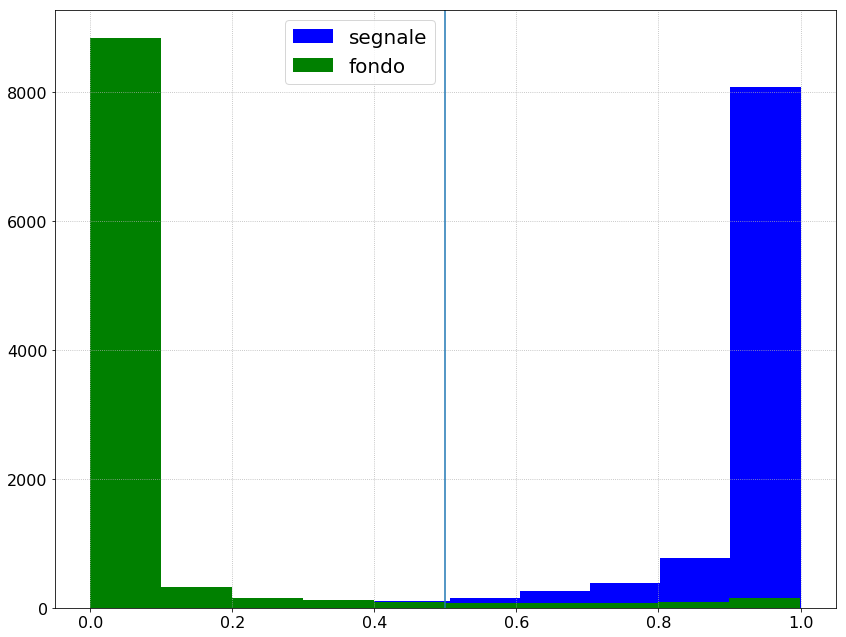

In [46]:
plt.hist(results_signal,10, color="b", label="segnale")
plt.hist(results_bkg,10, color="g", label="fondo")
plt.legend(bbox_to_anchor=(0.5, 1))
plt.axvline(x=0.5)
plt.show()

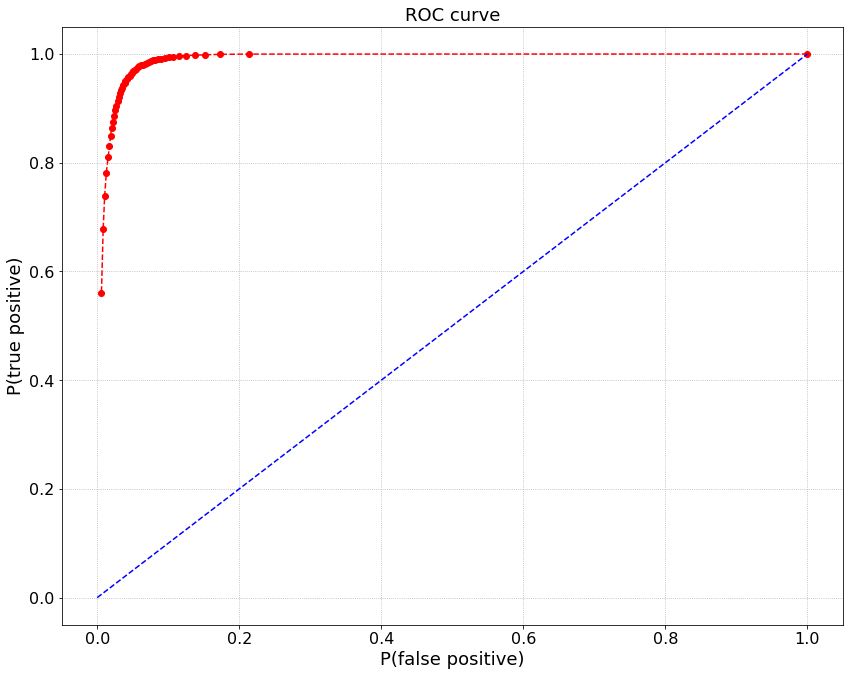

In [32]:
x = list(np.arange(0, 1, 0.02))
true_positive = []
false_positive = []

for xi in x:
    true_positive.append((results_signal>xi).sum()/ 10000)
    false_positive.append((results_bkg>xi).sum()/ 10000)
    
plt.plot(false_positive, true_positive, 'ro--')
plt.title("ROC curve")
plt.xlabel("P(false positive)")
plt.ylabel("P(true positive)")
plt.plot(np.linspace(0,1), np.linspace(0,1), 'b--')
plt.show()


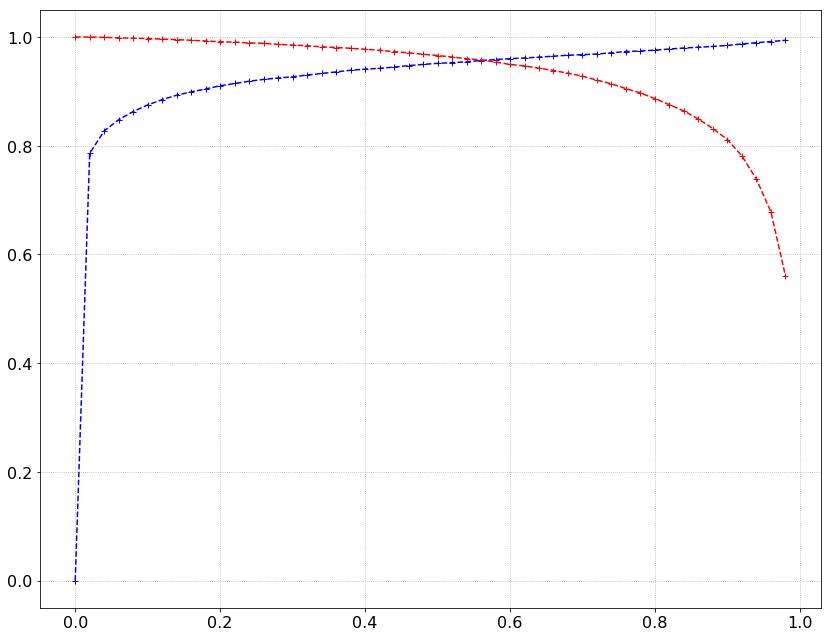

In [27]:
significance = 1 - np.array(false_positive)
plt.plot(x, significance, 'b+--')
plt.plot(x, true_positive, 'r+--')
plt.show()

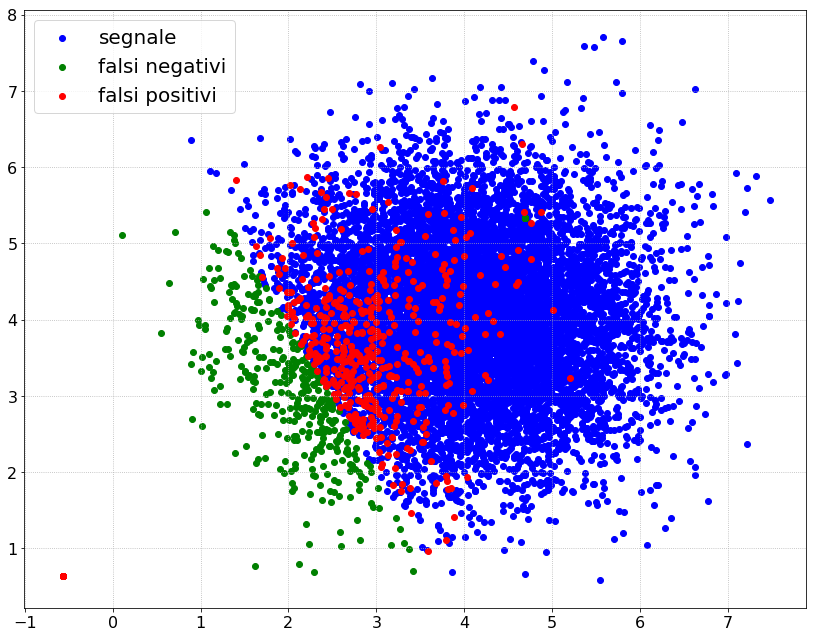

In [58]:
thresold = 0.5
x_signal, y_signal = signal_samples_test[np.argwhere(results_signal>thresold)].T
x_signal_bad, y_signal_bad = signal_samples_test[np.argwhere(results_signal<thresold)].T
x_bkg, y_bkg = bkg_samples_test[np.argwhere(results_bkg<thresold)].T
x_bkg_bad, y_bkg_bad = bkg_samples_test[np.argwhere(results_bkg>thresold)].T

plt.scatter(x_signal, y_signal, c='b', label="segnale")
plt.scatter(x_signal_bad, y_signal_bad, c='g', label="falsi negativi")
plt.scatter(x_bkg_bad, y_bkg_bad, c='r', label="falsi positivi")
plt.legend()
plt.show()

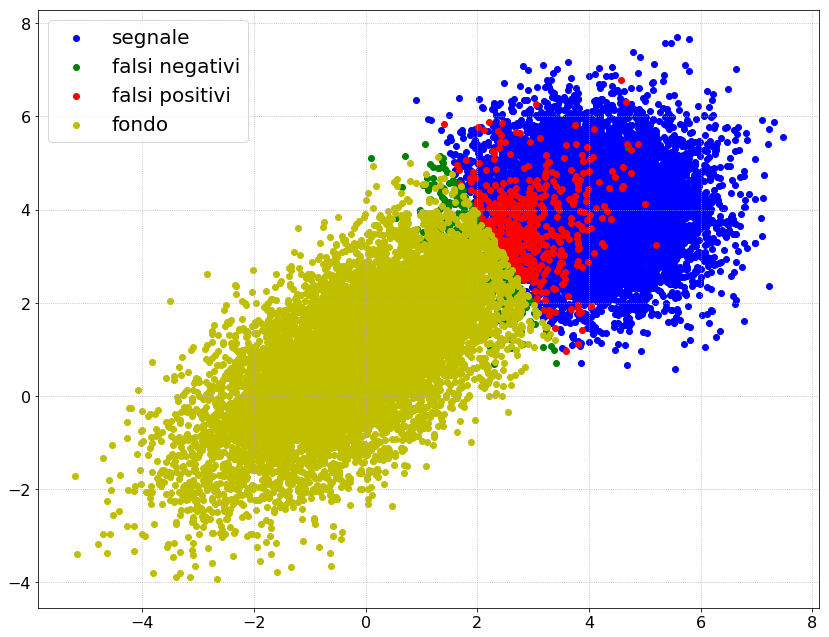

In [61]:
plt.scatter(x_signal, y_signal, c='b', label="segnale")
plt.scatter(x_signal_bad, y_signal_bad, c='g', label="falsi negativi")
plt.scatter(x_bkg_bad, y_bkg_bad, c='r', label="falsi positivi")
plt.scatter(x_bkg, y_bkg, c='y', label="fondo")
plt.legend()
plt.show()

In [31]:
model.save_weights("model.h5")